In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [19]:
# Nmax = 50
# N = 30

In [16]:
N = 50
outputs = np.zeros((N, N))
outputs = torch.Tensor(outputs)

In [24]:
mask_upper = torch.triu(torch.ones_like(outputs))
#mask_lower = torch.tril(torch.ones_like(outputs), diagonal=1)
masking = (1 - mask_upper)# * (1 - mask_lower)

In [25]:
outputs = outputs * masking

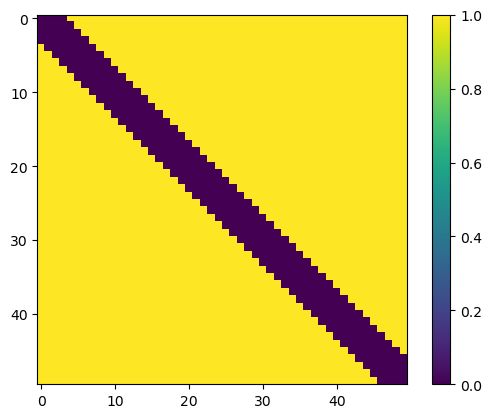

In [32]:
N = 50
outputs = np.zeros((N, N))
outputs = torch.Tensor(outputs)
#outputs = np.zeros((N, N))
row_up, col_up = torch.triu_indices(N, N, offset=4)
row_low, col_low = torch.tril_indices(N, N, offset=-4)
outputs[row_up, col_up] = 1
outputs[row_low, col_low] = 1

fig, ax = plt.subplots()
im = ax.imshow(outputs)
fig.colorbar(im)
plt.show()

In [1]:
# standard lib
import os
from pathlib import Path
from typing import Optional, Dict

# scientific libs
import numpy as np
import pandas as pd

# DL libs
import torch
import torchvision
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import esm
from esm.data import ESMStructuralSplitDataset
from sklearn.metrics import roc_auc_score

# graph libs
import matplotlib.pyplot as plt

#from esm_utils import *
from tqdm import tqdm

In [2]:
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()

# Freeze all parameters of the pretrained model
for param in model.parameters():
    param.requires_grad = False

In [3]:
train_dataset = ESMStructuralSplitDataset(
    split_level='superfamily', 
    cv_partition='4', 
    split='train', 
    root_path = os.path.expanduser('~/.cache/torch/data/esm'),
)

valid_dataset = ESMStructuralSplitDataset(
    split_level='superfamily', 
    cv_partition='4', 
    split='valid', 
    root_path = os.path.expanduser('~/.cache/torch/data/esm'),
)

In [4]:
# Prepare data, optimizer, and objective/loss function
batch_converter = alphabet.get_batch_converter()

contact_threshold = 15

In [5]:
rand_example = np.random.randint(len(valid_dataset))
rand_target = valid_dataset[rand_example]

print(f"Data point {rand_example}, {rand_target['seq']}")

Data point 1955, DVQLVESGGGLVQPGGSLRLSCAASESILSFNHMAWYRQGPGEQRELVAVITREGSTDYADSVKGRFTISRDNAKNMVYLLMSNLRPEDTAVYYCNRGISNPWGQGTQVTVS


In [6]:
batch_labels, batch_strs, batch_tokens = batch_converter([(rand_example, rand_target["seq"])])
rand_target_c = rand_target['dist'] <= contact_threshold

outputs = model(batch_tokens, return_contacts=True)

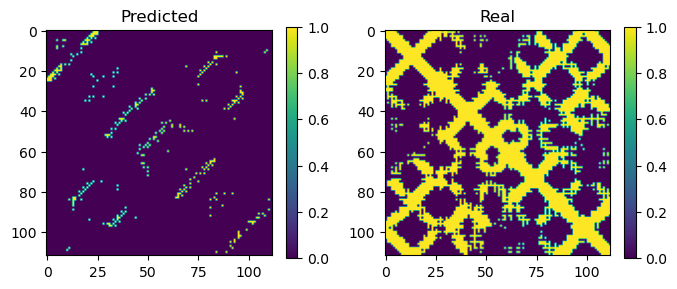

In [7]:
N = len(batch_strs[0])
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
im = ax[0].imshow(outputs['contacts'][0].detach().numpy() > 0.5)
fig.colorbar(im)
ax[0].set_title("Predicted")
im = ax[1].imshow(rand_target_c) #['dist'] <= contact_threshold)
fig.colorbar(im)
ax[1].set_title("Real")
plt.show()

In [8]:
# Modify only the last layer for regression task
model.contact_head.regression = nn.Linear(in_features=model.contact_head.regression.in_features, out_features=1)

# Set requires_grad=True only for the regression layer parameters to be trained
for param in model.contact_head.regression.parameters():
    param.requires_grad = True

In [9]:
for param in model.contact_head.regression.parameters():
    param.requires_grad = True
    
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

contact_head.regression.weight
contact_head.regression.bias


In [10]:
# remove all the nans
masked_train = []
masked_valid = []

# modify dataset to remove/mask entries without any coordinates/distances
for t in train_dataset:
    mask = ~np.isnan(t["coords"].sum(axis=1))
    mdist = t["dist"][mask][:, mask]
    masked_entry = {
        "seq": "".join(c for c, cm in zip(t['seq'], mask) if cm),
        "ssp": "".join(c for c, cm in zip(t['ssp'], mask) if cm),
        "coords": t["coords"][mask],
        # Boolean values to only recognise distances up to a threshold of 15A
        "dist": mdist <= contact_threshold
    }
    masked_train.append(masked_entry)
    
for t in valid_dataset:
    mask = ~np.isnan(t["coords"].sum(axis=1))
    mdist = t["dist"][mask][:, mask]
    masked_entry = {
        "seq": ''.join(c for c, cm in zip(t["seq"], mask) if cm),
        "ssp": ''.join(c for c, cm in zip(t["ssp"], mask) if cm),
        "coords": t["coords"][mask],
        "dist": mdist <= contact_threshold
    }
    masked_valid.append(masked_entry)

In [11]:
print(masked_train[0]['dist'])

[[ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 ...
 [False False False ...  True  True  True]
 [False False False ...  True  True  True]
 [False False False ...  True  True  True]]


In [12]:
device = torch.device("cpu")
# if torch.backends.cuda.is_built():
#     device = torch.device("cuda")
# elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
#     device = torch.device("mps")
print(f"Using device {device}")

Using device cpu


In [14]:
# Training loop
learning_rate = 0.001

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
               
# loss is calculated for each input and target pair, mean values calculated manually
loss_fn = nn.BCELoss(reduction="none")

num_epochs = 2

print(f"Epoch\tTrain loss\tTest loss")
for epoch in range(num_epochs):
    model.train()
               
    # Initialise loss for each epoch   
    total_loss = 0
    # Number of sequences used to train model (80/12312 samples)
    tsize = 8
    # Training on randomly selected sequences in batches of 10
    for b in tqdm(
        DataLoader(np.random.choice(len(masked_train), size=tsize, replace=False), batch_size=8, shuffle=True),
    ncols=40):
        # Tokenise input sequences
        batch_labels, batch_strs, batch_tokens = batch_converter([(i, masked_train[i]["seq"]) for i in b])
        # Clear gradients for each epoch
        optimizer.zero_grad()
        # Output predictions for batch 
        outputs = model(batch_tokens.to(device), return_contacts=True)
        
        # Apply triangle tensor masking to targets
        # mask_upper = torch.triu(torch.ones_like(outputs["contacts"]), diagonal=4)
        # mask_lower = torch.tril(torch.ones_like(outputs["contacts"]), diagonal=-4)
        # masking = (1 - mask_upper) * (1 - mask_lower)
        
        # Initialise objects to 0 to match the format of contact output tensor
        targets = torch.zeros_like(outputs["contacts"])
        
        # targets = targets[np.triu_indices(N, 4)] = 1
        # targets = targets[np.tril_indices(N, -4)] = 1
        target_mask = torch.zeros_like(outputs["contacts"])
        
        mask = torch.zeros_like(outputs["contacts"])
        
        # Pull masked and threshold normalised distance values from sequences trained on 
        for i_, ti in enumerate(b):
            dm = masked_train[ti]["dist"]
            N = dm.shape[0]
            targets[i_, :N, :N] = torch.tensor(dm)
            
            row_up, col_up = torch.triu_indices(N, N, offset=4)
            row_low, col_low = torch.tril_indices(N, N, offset=-4)
            target_mask[i_, row_up, col_up] = 1
            target_mask[i_, row_low, col_low] = 1
           
            targets = targets * target_mask
            mask[i_, :N, :N] = 1

        #targets = targets * masking
    
        # Calculates smooth L1 loss between predictions and true values
        loss = loss_fn(outputs["contacts"], targets)
        # Manually calculate mean per run (reduction = "none")
        loss = (loss * mask).mean()
        # Pool loss values from each batch
        total_loss += loss.item()
        # Backpropagation
        loss.backward()
        # Updates last layer parameters to reduce loss
        optimizer.step()
        del batch_tokens, targets, mask
    
    valid_loss = 0
    vsize = 1
    for b in DataLoader(range(vsize), batch_size=1, shuffle=True):
        batch_labels, batch_strs, batch_tokens = batch_converter([(i, masked_valid[i]["seq"]) for i in b])
        inputs = batch_tokens
        # contacts
        targets = torch.tensor(np.array([masked_valid[i]["dist"] for i in b]), dtype=torch.float32)
        outputs = model(batch_tokens.to(device), return_contacts=True)
        # Calculates binary cross entropy loss between predictions and true values
        loss = nn.BCELoss()(outputs["contacts"], targets)
        # Pool loss values from each batch
        valid_loss += loss.item()
        del batch_tokens, targets
    # Print loss per epoch 
    average_loss = total_loss / tsize
    average_loss_test = valid_loss / vsize
    
    # Print AUC per epoch
    #auc_score = roc_auc_score(targets, outputs)
    
    # # For animated gif example
    # batch_labels, batch_strs, batch_tokens = batch_converter([(rand_example, rand_target["seq"])])
    # outputs = model(batch_tokens.to(device), return_contacts=True)
    # del batch_tokens
    # outputs_conts.append(outputs["contacts"][0].detach().numpy())
    
    print(f"{epoch+1}/{num_epochs}\t{average_loss:.4f}\t{average_loss_test:.4f}")
    #print("AUC Score:", auc_score)

Epoch	Train loss	Test loss


100%|█████| 1/1 [00:39<00:00, 39.60s/it]


1/2	0.0302	0.7008


100%|████| 1/1 [01:59<00:00, 119.10s/it]


2/2	0.0192	0.7006


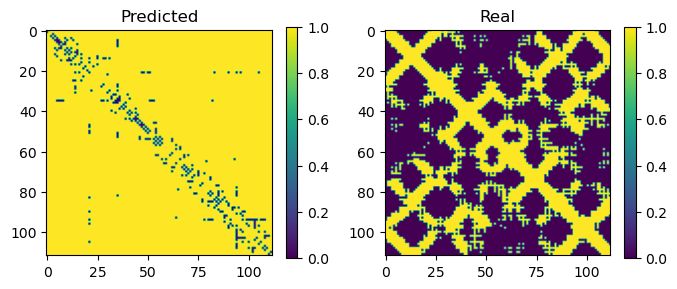

In [15]:
batch_labels, batch_strs, batch_tokens = batch_converter([(rand_example, rand_target["seq"])])
#rand_target_c = rand_target['dist'] <= contact_threshold

outputs = model(batch_tokens, return_contacts=True)

N = len(batch_strs[0])
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
im = ax[0].imshow(outputs['contacts'][0].detach().numpy() > 0.5)
fig.colorbar(im)
ax[0].set_title("Predicted")
im = ax[1].imshow(rand_target_c)
fig.colorbar(im)
ax[1].set_title("Real")
plt.show()